### **Вступ**

Це проект аналізує діяльність по шахрайським злочинам в онлайн -платежах. Я буду досліджувати дані,  які у нас є та намагатись знайти закономірності та цікаві аспекти, які допоможуть зрозуміти патерни поведінки шахраїв та звернути увагу бізнесу на них.


### **Збір даних**

Я знайшла ці дані на платформі [kaggle](https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset/data) та завантажила їх у форматі csv.

Далі буду завантажувати вже їх з гугл диску.

Дані оновлені були у 2022 році.

### **Опис колонок**

`step`: представляє одиницю часу, де 1 крок дорівнює 1 годині

`type`: тип онлайн-транзакції

`amount`: сума транзакції

`nameOrig`: клієнт, що починає транзакцію

`oldbalanceOrg`: баланс до транзакції

`newbalanceOrig`: баланс після транзакції

`nameDest`: отримувач транзакції

`oldbalanceDest`: початковий баланс отримувача до транзакції

`newbalanceDest`: новий баланс отримувача після транзакції

`isFraud`: шахрайська транзакція

`isFlaggedFraud` : позначка від автоматичної системи, що це шахрайська дія

### **1. Імпортую всі необхідні бібліотеки**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### **2. Зчитую дані**

In [2]:
data = '/content/drive/MyDrive/Курс Дата аналітик /Data/Dataset for project/dataOnline_Payments_Fraud_Detection_Dataset.csv'
df = pd.read_csv(data)

🔹 Перевіряю основну інформацію про дані, виводжу кількість рядків та колонок та показую перші 5 рядків

In [3]:
df.info()

num_rows, num_cols = df.shape
print(f'Набір містить {num_rows} рядків та {num_cols} колонок.')

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Набір містить 6362620 рядків та 11 колонок.


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


🔹 Змінюю деякі типи даних для зручності

In [4]:
df['type'] = df['type'].astype('category')

In [5]:
print(df.dtypes)

step                 int64
type              category
amount             float64
nameOrig            object
oldbalanceOrg      float64
newbalanceOrig     float64
nameDest            object
oldbalanceDest     float64
newbalanceDest     float64
isFraud              int64
isFlaggedFraud       int64
dtype: object


🔹 Аналізую пропущені значення та дублікати в датасеті

In [6]:
print(df.isnull().sum())

duplicates = df.duplicated().sum()
print(f"Кількість дублікатів: {duplicates}")

# Якщо є дублікати, відразу їх видаляю
df = df.drop_duplicates()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Кількість дублікатів: 0


✔️ Бачу, що пропущених значень та дублікатів немає.

🔹 Перевіряю кількість унікальних транзакцій відправників та отримувачів

In [7]:
print(f"Кількість унікальних відправників: {df['nameOrig'].nunique()}")
print(f"Кількість унікальних отримувачів: {df['nameDest'].nunique()}")

Кількість унікальних відправників: 6353307
Кількість унікальних отримувачів: 2722362


✔️ Бачимо, що кількість отримувачів значно менша. Можливо в цьому є вузьке місце. І тут потрібно дослідити більш детально саме отримувачів.

🔹 Дивлюсь скільки саме у нас шахрайських транзакцій у відсотках. Та цікаво буде візуалізувати її.


isFraud
0    99.87
1     0.13
Name: proportion, dtype: float64


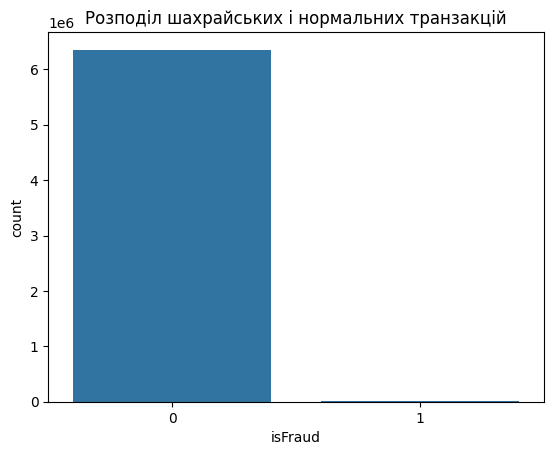

In [8]:
fraud_distribution = df['isFraud'].value_counts(normalize=True) * 100
print(fraud_distribution.round(2))


sns.countplot(x='isFraud', data=df)
plt.title("Розподіл шахрайських і нормальних транзакцій")
plt.show();

✔️ Частка шахрайських дій:

`0 `    **99.87**       #Нормальні транзакції (99.87%)

`1 `    **0.13**        #Шахрайські транзакції (0.13%)


Бачимо дуже сильний дизбаланс.

### **3. Детальніший аналіз даних таблиці.**

Аналіз транзакцій, які ми маємо. Їх кількість, тип та сума коштів яка була задіяна.


🔹 Кількість транзакцій за типами

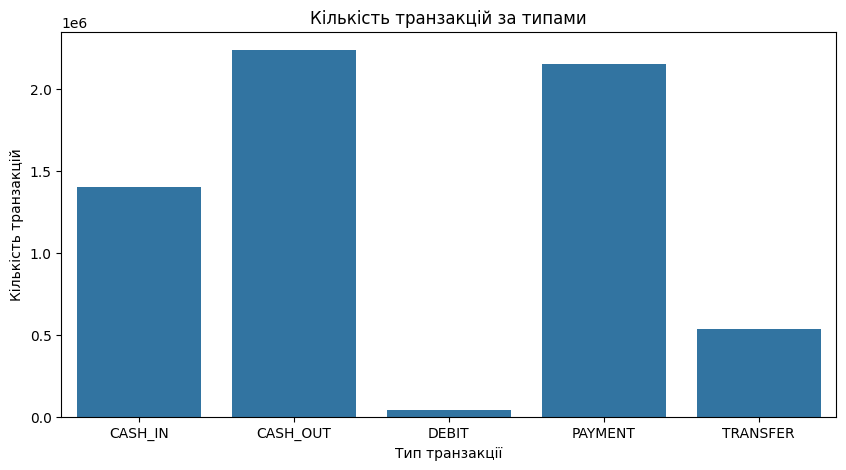

In [9]:
transaction_count_by_type = df['type'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=transaction_count_by_type.index, y=transaction_count_by_type.values)
plt.title("Кількість транзакцій за типами")
plt.xlabel("Тип транзакції")
plt.ylabel("Кількість транзакцій")
plt.show();

🔹 Загальна сума транзакцій за типами

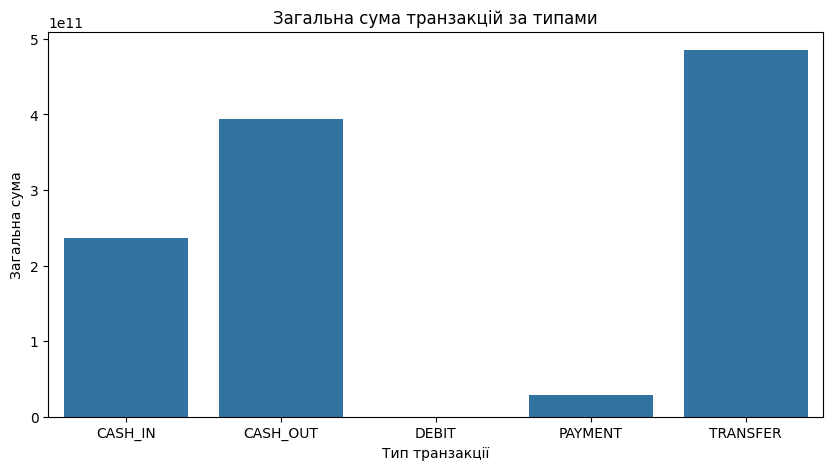

In [10]:
total_amount_by_type = df.groupby('type', observed=False)['amount'].sum().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=total_amount_by_type.index, y=total_amount_by_type.values)
plt.title("Загальна сума транзакцій за типами")
plt.xlabel("Тип транзакції")
plt.ylabel("Загальна сума")
plt.show();

🔹 Візуалізація середніх сум для різних типів транзакцій

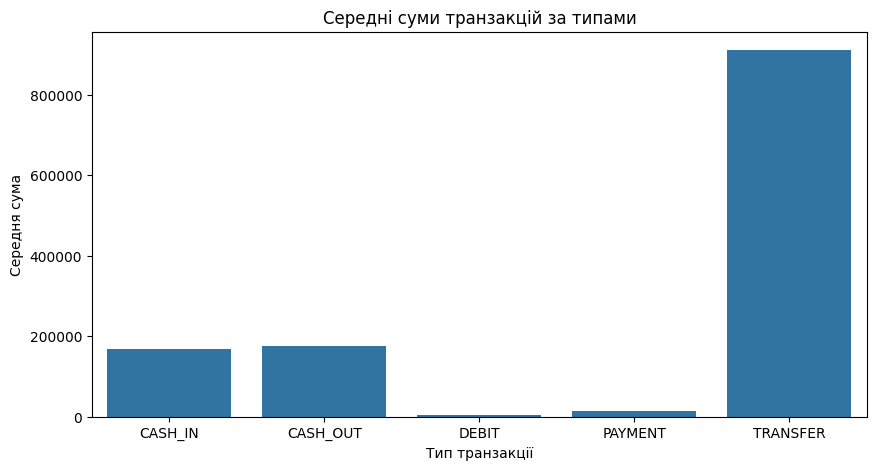

In [11]:
avg_amount_by_type = df.groupby('type', observed=False)['amount'].mean().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=avg_amount_by_type.index, y=avg_amount_by_type.values)
plt.title("Середні суми транзакцій за типами")
plt.xlabel("Тип транзакції")
plt.ylabel("Середня сума")
plt.show();

### **4. Аналіз даних з питаннями.**

**❓ 4.1 - Який відсоток шахрайських транзакцій система виявила (`isFlaggedFraud` = 1)?**

🔹 Порахую загальну кількість шахрайських дій та кількість транзакцій, які були помічені системою та визначимо відсоток.

In [12]:
total_fraud = df.query("isFraud == 1").shape[0]

flagged_fraud = df.query("isFraud == 1 and isFlaggedFraud == 1").shape[0]

fraud_detection_rate = (flagged_fraud / total_fraud) * 100 if total_fraud > 0 else 0

print(f"Загальна кількість шахрайських транзакцій: {total_fraud}")
print(f"Кількість шахрайських транзакцій, позначених системою: {flagged_fraud}")
print(f"Відсоток виявлених шахрайських транзакцій: {fraud_detection_rate:.2f}%")

Загальна кількість шахрайських транзакцій: 8213
Кількість шахрайських транзакцій, позначених системою: 16
Відсоток виявлених шахрайських транзакцій: 0.19%


✔️ Бачимо, що система помічає шахрайські транзакції дуже рідко—лише 0.19% із загальної кількості.

Це означає, що алгоритм, який позначає підозрілі транзакції `isFlaggedFraud`, працює недостатньо ефективно. Потрібно його доопрацювати.

❓**4.2 - Які є характеристики шахрайських транзакцій?**

🔹 Виведу всі шахрайські транзакції, які були позначені системою

In [13]:
flagged_fraud_transactions = df[df['isFlaggedFraud'] == 1]


print("Характеристики шахрайських транзакцій, позначених системою:")
print(flagged_fraud_transactions.describe())

Характеристики шахрайських транзакцій, позначених системою:
             step        amount  oldbalanceOrg  newbalanceOrig  \
count   16.000000  1.600000e+01   1.600000e+01    1.600000e+01   
mean   537.562500  4.861598e+06   7.817869e+06    7.817869e+06   
std    181.895196  3.572499e+06   6.972669e+06    6.972669e+06   
min    212.000000  3.538742e+05   3.538742e+05    3.538742e+05   
25%    415.500000  2.242749e+06   3.013980e+06    3.013980e+06   
50%    601.500000  4.234245e+06   4.923043e+06    4.923043e+06   
75%    678.750000  7.883451e+06   1.212835e+07    1.212835e+07   
max    741.000000  1.000000e+07   1.958504e+07    1.958504e+07   

       oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
count            16.0            16.0     16.0            16.0  
mean              0.0             0.0      1.0             1.0  
std               0.0             0.0      0.0             0.0  
min               0.0             0.0      1.0             1.0  
25%               0.

 ✔️ Бачимо, що середній крок `step` ≈ 537, а максимальний 741.
 Це може означати, що шахраї діють не хаотично, а на певних етапах у процесі.

 Це може бути також харектеристикою з якою потрібно попрацювати в системі, щоб звернути на це увагу, як один з фільтрів виявлення шахрайських транзакцій.

**❓4.3 - Чи є різниця в середніх сумах шахрайських транзакцій із тими, що були позначені системою?**

🔹 Виведу середні суми шахрайських транзакцій та ті, що були позначені системою

In [14]:
avg_fraud_amount = df[df['isFraud'] == 1]['amount'].mean()
avg_flagged_fraud_amount = flagged_fraud_transactions['amount'].mean()

print(f"\nСередня сума шахрайських транзакцій: {avg_fraud_amount:,.2f}")
print(f"Середня сума позначених системою шахрайських транзакцій: {avg_flagged_fraud_amount:,.2f}")


Середня сума шахрайських транзакцій: 1,467,967.30
Середня сума позначених системою шахрайських транзакцій: 4,861,597.73


✔️ З аналізу видно, що середня сума всіх шахрайських транзакцій ≈ 1.47 млн  
Середня сума позначених системою ≈ 4.86 млн  

Це означає, що система майже не помічає дрібних шахрайських транзакцій і реагує лише на дуже великі суми. Що теж може бути поганою характеристикою системи. Та тут можна працювати над вдосконаленням.

**❓4.4 - Чи впливає шахрайство на зміну балансів рахунків?**

🔹 Порахую баланси на основі таблиці нашої та побудую зведену таблицю для аналізу

In [15]:
df['balance_change_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [16]:
pivot_table_balance_change = df.pivot_table(
    values=['balance_change_orig', 'balance_change_dest'],
    index='isFraud',
    aggfunc='mean'
)

# Округлюю результати для легшого аналізу
pivot_table_balance_change = pivot_table_balance_change.round(2)

print(pivot_table_balance_change)

         balance_change_dest  balance_change_orig
isFraud                                          
0                  123504.81             23141.52
1                  735458.00          -1457274.97


✔️ **Для НЕ шахрайських транзакцій:**

- відправники втрачають середньо 23,141.52

- отримувачі отримують в середньому 123,504.81

Це відповідає нормальному функціонуванню фінансових транзакцій, де відправник передає гроші, а отримувач їх отримує.


**Для шахрайських транзакцій:**

- середня сума отримана отримувачами становить 735,458.00

-  відправники **втрачають** 1,457,274.97

Це свідчить про те, що шахрайські транзакції пов'язані з набагато більшими сумами втрат для відправників і великими виплатами для отримувачів.

Отже, **отримувачі шахрайських транзакцій отримують набагато більші суми, що є характерною ознакою незаконних операцій.**
Варто цей критерій також взяти для доопрацьовання системи.

**❓4.5 -  Який середній розмір транзакцій для шахрайських і не шахрайських операцій за різними типами транзакцій?**

 🔹 Створю зведену таблицю, яка покаже середній розмір транзакцій за типами та ознакою шахрайства

In [17]:
pivot_table_avg_amount_by_fraud_type = df.pivot_table(
    values='amount',
    index=['isFraud', 'type'],
    aggfunc='mean',
    observed=True
)

# Округлюю результати для легшого аналізу
pivot_table_avg_amount_by_fraud_type = pivot_table_avg_amount_by_fraud_type.round(2)

print(pivot_table_avg_amount_by_fraud_type)

                      amount
isFraud type                
0       CASH_IN    168920.24
        CASH_OUT   173917.16
        DEBIT        5483.67
        PAYMENT     13057.60
        TRANSFER   906229.01
1       CASH_OUT  1455102.59
        TRANSFER  1480891.67


✔️ Для шахрайських транзакцій найбільші середні суми спостерігаються  у `CASH_OUT` та `TRANSFER`. Це може свідчити про те, що шахраї часто використовують саме ці типи операцій для переказу великих сум.

Середні суми для шахрайських транзакцій значно більші, ніж для не шахрайських. Це може вказувати на те, що шахрайство часто включає великі суми.

Варто звертати увагу більше на саме ці категорії транзакцій.

**❓4.6 - Які типи транзакцій найбільш схильні до шахрайства у відсотках?**
*(це питання буде гарним доповненням та перевіркою попереднього)*

🔹 Обчислю кількість шахрайських транзакцій за типами, потім загальну кільсть транзакцій і потім порахую відсоток.

In [18]:
fraud_by_type = df[df['isFraud'] == 1].groupby('type', observed=False).size()

total_fraud = df[df['isFraud'] == 1].shape[0]  # Загальна кількість шахрайських транзакцій

fraud_distribution = ((fraud_by_type / total_fraud) * 100).round(2)

print(fraud_distribution)

type
CASH_IN      0.00
CASH_OUT    50.12
DEBIT        0.00
PAYMENT      0.00
TRANSFER    49.88
dtype: float64


✔️ Типи транзакцій найбільш схильні до шахрайства: `CASH_OUT` (50,12%) і `TRANSFER` (49,88%).

**❓4.7 - Як змінилася кількість транзакцій з часом?**

🔹 *нагадування*

1 крок = 1 год

Покажу на графіку як з часом змінюються транзакції.

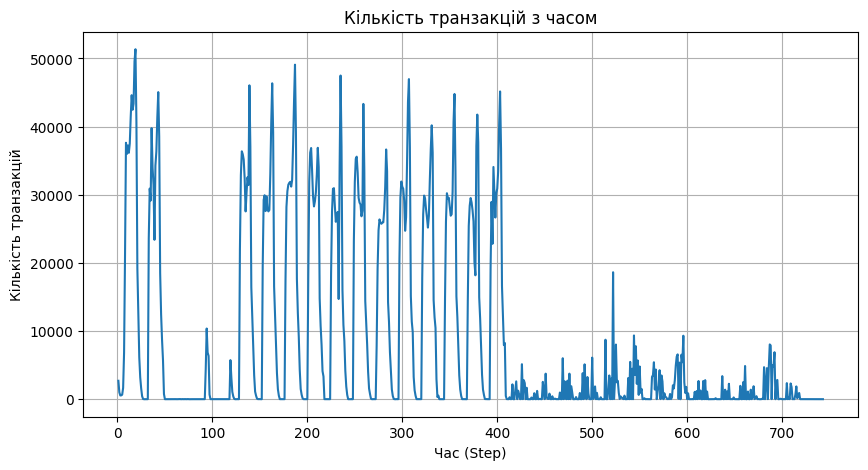

In [19]:
transactions_over_time = df.groupby('step').size()

plt.figure(figsize=(10, 5))
transactions_over_time.plot(kind='line')
plt.title("Кількість транзакцій з часом")
plt.xlabel("Час (Step)")
plt.ylabel("Кількість транзакцій")
plt.grid(True)
plt.show();

✔️ На графіку видно, що з часом кількість транзакцій значно зменшилась. Після 400 годин активність знизилась у сотні разів.

**❓4.8 - А чи змінилась активність шахрайських транзакцій з часом? Чи вона має якусь залежність від звичайних транзакцій?**

🔹 Візуалізую вже тільки графік шахрайських транзакцій.

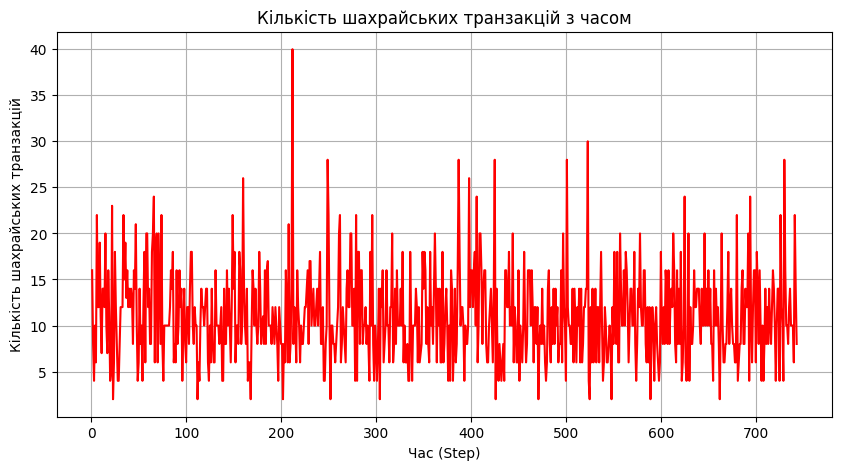

In [20]:
fraud_transactions = df[df['isFraud'] == 1]
fraud_transactions_over_time = fraud_transactions.groupby('step').size()

plt.figure(figsize=(10, 5))
fraud_transactions_over_time.plot(kind='line', color='red')
plt.title("Кількість шахрайських транзакцій з часом")
plt.xlabel("Час (Step)")
plt.ylabel("Кількість шахрайських транзакцій")
plt.grid(True)
plt.show();

✔️ На графіку видно, що шахрайські дії завжди мають динаміку, на відміну від загальної кількості. Тобто можемо зробити висновок, що скільки б не було загальної кількості транзакцій, шахрайські всеодно відбуваються. Можливо це також можна використати для виявлення ким саме вони були виконані.

**❓4.9 - Чи є імена клієнтів `nameOrig`, які декілька разів зустрічаються в шахрайських транзакціях?**


In [21]:
# Фільтрую шахрайські транзакції
fraud_transactions = df[df['isFraud'] == 1]

# Підраховую кількість шахрайських транзакцій для кожного nameOrig
fraud_by_nameOrig = fraud_transactions['nameOrig'].value_counts()

# Фільтрую тільки ті nameOrig, які мають рівно одну шахрайську транзакцію
fraud_by_nameOrig_one = fraud_by_nameOrig.loc[fraud_by_nameOrig == 1]

# Фільтрую тільки ті nameOrig, які мають більше одного разу
fraud_by_nameOrig_more_than_1 = fraud_by_nameOrig.loc[fraud_by_nameOrig > 1]

# Перевіряю, чи є клієнти, які мають тільки одну шахрайську транзакцію
if len(fraud_by_nameOrig_one) == 0:
    print("\n\nТаких клієнтів немає.")
else:
    print(f"Імена клієнтів, які мають тільки одну шахрайську транзакцію: \n{fraud_by_nameOrig_one}")

# Виводжу список з іменами клієнтів, які мають більше 1 шахрайської транзакції
if len(fraud_by_nameOrig_more_than_1) == 0:
    print("\n\nТаких клієнтів, які мають більше 1 шахрайську транзакцію, немає.")
else:
    print(f"Імена клієнтів, які мають більше 1 шахрайську транзакцію: \n{fraud_by_nameOrig_more_than_1}\n")

Імена клієнтів, які мають тільки одну шахрайську транзакцію: 
nameOrig
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
              ..
C570536992     1
C980546604     1
C58682758      1
C351713185     1
C1280323807    1
Name: count, Length: 8213, dtype: int64


Таких клієнтів, які мають більше 1 шахрайську транзакцію, немає.


**❓4.10 - Чи є однакові імена відправників та одержувачів?**

In [22]:
# Знаходжу спільні імена в таблицях одержувачів та відправників
common_names = np.intersect1d(df['nameOrig'].values, df['nameDest'].values)

# Знаходжу шахрайські операції, де ім'я відправника і одержувача є у спільних іменах
fraud_transactions = df[df['isFraud'] == 1]

fraud_common_names = fraud_transactions[
    fraud_transactions['nameOrig'].isin(common_names) | fraud_transactions['nameDest'].isin(common_names)
]

# Кількість шахрайських транзакцій із спільними іменами
fraud_common_count = len(fraud_common_names)

# Загальна кількість шахрайських транзакцій
total_fraud_count = len(fraud_transactions)

# Обчислюю відсоток таких транзакцій
fraud_common_percentage = (fraud_common_count / total_fraud_count) * 100 if total_fraud_count > 0 else 0

if common_names.size > 0:
    print(f"Кількість спільних імен: {len(common_names)}")
    print(f"Приклади: {common_names[:10]}")
else:
    print("Спільних імен немає.")
print(f"Кількість шахрайських транзакцій зі спільними іменами: {fraud_common_count}")
print(f"Відсоток таких транзакцій від всіх шахрайських: {fraud_common_percentage:.2f}%")


Кількість спільних імен: 1769
Приклади: ['C1000194623' 'C1000836905' 'C1002007146' 'C1002075438' 'C1003902725'
 'C100403476' 'C1004038224' 'C1005068442' 'C1005914856' 'C1007627233']
Кількість шахрайських транзакцій зі спільними іменами: 18
Відсоток таких транзакцій від всіх шахрайських: 0.22%


✔️ Бачимо, що у нас є 18 однакових імен в шахрайських транзакціях. А значить ці шахраї використовують однакові аккаунти для відправки та отримання коштів.

Ймовірно вони можуть повторно використовувати ті самі рахунки, щоб легалізувати кошти або "замітати сліди".

Можливо, деякі з цих операцій — це спроби відмивання грошей через мережу підставних акаунтів.

Ці моменти потрібно врахувати також при подальшій розробці програми по виявленню шахраїв. Адже тут спостерігаємо певний патерн повторного використання акаунтів. Це може бути частиною складнішої схеми шахрайства, де зловмисники пересилають кошти між власними рахунками, перш ніж вивести їх.

### **5. Висновки**

📌 Система яка вже є, ймовірно, має обмежений поріг, який вона використовує для позначення підозрілих транзакцій (≈ 5 млн).  
А тому щахраї можуть уникати виявлення, розбиваючи велику суму на кілька дрібних платежів. Варто доопрацювати систему.

📌 Система розпізнає дуже маленький відсоток шахрайських дій самостійно (0,19%), тому точно потрібно працювати над її вдосконаленням.

📌 Точно потрібно звертати більше уваги на транзакції з типом `CASH_OUT` та `TRANSFER`. Адже поки аналіх показує, що ці транзакції найбільше користуються попитом у шахраїв.


📌 Потрібно прослідкувати за тими клієнтами, які зустрічаються як шахраї, а потім проводять додатково ще транзакції, і система їх вже не помічає. Можливо гроші перекидуються на інші рахунки, щоб їх не можна було знайти.

📌 Було б добре збільшити таблицю даних новими колонками, тобто зібрати додаткову інформацію, яка б допомагала потім в аналізі.
А саме, можна додатково дізнатись:
- дні транзакцій,
- країни чи регіони де була транзакція,
- назва банку чий рахунок використовувся,
- як довго клієнт є в базі (він новий чи ні),
- чи є траназакції, які по якимсь обставинам скасовуються,
- термін здійснення транзакції,
- сайт де була здійснена транзакція.

Ці дані допомогли б ще більше проаналізувати поведінку шахраїв.